https://pylessons.com/Keras-ResNet-tutorial

### Imports and installations, PATH

In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input

2023-05-03 15:59:24.246988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
PATH = "."

### Helper functions

In [3]:
def plot_history(hist_baseline, hist_regularized = None, dataset="WGA"):
   
    fig = plt.figure(figsize = (17,5))
    metrics = ["loss", "accuracy"]
    
    for i in range(len(metrics)):
        metric = metrics[i]
        plt.subplot(1, 2, i+1)
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        br_epoha = len(hist_baseline.history[metric])
        plt.plot(range(1, br_epoha + 1), hist_baseline.history[metric], 
                 label=f"{dataset} train", color = "tab:blue")
        plt.plot(range(1, br_epoha + 1), hist_baseline.history["val_" + metric], 
                 label=f"{dataset} validation", color = "tab:orange")
        plt.ylim(bottom=0)

        if hist_regularized:
            br_epoha = len(hist_regularized.history[metric])
            plt.plot(range(1, br_epoha + 1), hist_regularized.history[metric], 
                 label="regularized train", color = "tab:blue", linestyle = '--')
            plt.plot(range(1, br_epoha + 1), hist_regularized.history["val_" + metric], 
                 label="regularized val", color = "tab:orange", linestyle = '--')
        plt.legend()

### Data loading and preprocessing

In [4]:
# no = 3

images = np.load(os.path.join(PATH, "final_dataset", f"wga_images.npy"), allow_pickle=True, mmap_mode="r+")
labels = np.load(os.path.join(PATH, "final_dataset", f"wga_labels.npy"))
labels = np.array([lbl - 1 for lbl in labels])

In [14]:
images.shape[0]

(11467, 300, 300, 3)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels)

### Fine-tuning on imagenet

In [6]:
in_shape = images.shape[1:]
number_of_classes = len(set(labels))

#### ResNet50

In [7]:
# X_train = resnet_preprocess_input(X_train)
# X_test = resnet_preprocess_input(X_test)

In [28]:
def load_data(ids, resnet_preprocess=True):
    X = []
    Y = []
   
    for i in ids:
        X.append(X_train[i])
        Y.append(y_train[i])
       
    if resnet_preprocess:
        X = resnet_preprocess_input(np.array(X))

    return X, np.array(Y)

def batch_generator(ids, batch_size = 16):
    batch=[]
    while True:
        np.random.shuffle(ids)
        for i in ids:
            batch.append(i)
            if len(batch)==batch_size:
                yield load_data(batch)
                batch=[]

In [25]:
ids = np.arange(X_train.shape[0])
np.random.shuffle(ids)

train_generator = batch_generator(ids, batch_size = 16)

In [26]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=in_shape)
resnet.trainable = False 

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)


In [27]:
model_6 = Sequential([
     resnet,
     Flatten(),
     Dense(256, activation='relu'),
     Dense(128, activation='relu'),
     Dense(number_of_classes, activation='softmax')])

model_6.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [30]:
history_6 = model_6.fit(train_generator, epochs=30, verbose=2) # callbacks=[early_stop]

Epoch 1/30


2023-05-03 16:38:00.714713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [ ]:
model_6.save(os.path.join(PATH, "models", "wga_resnet_finetune.h5"))

In [ ]:
model_6.evaluate(X_test, y_test)

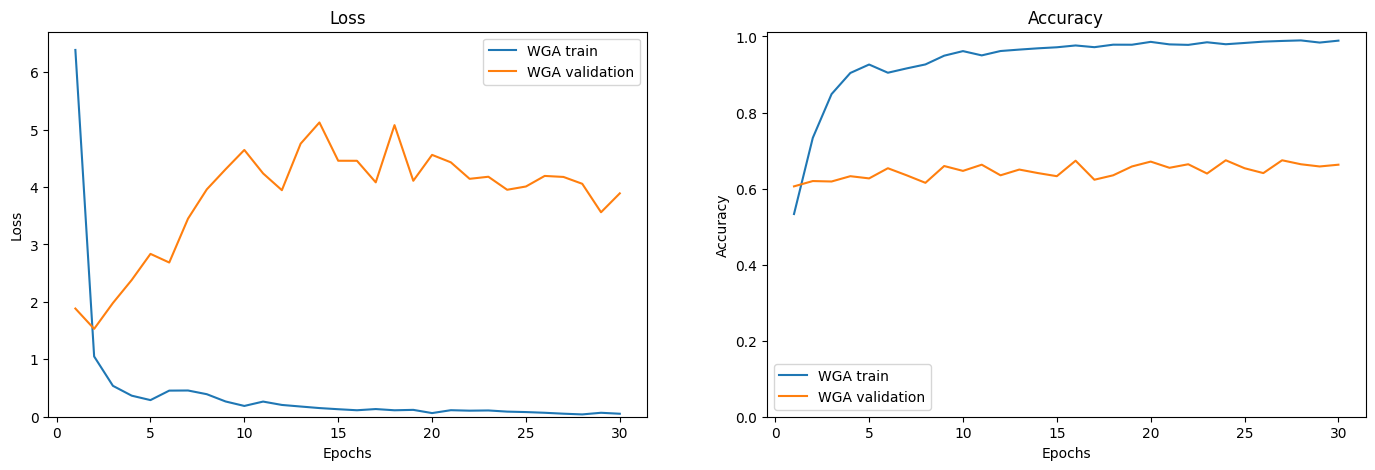

In [ ]:
plot_history(history_6)

In [ ]:
resnet = ResNet50(weights=None, include_top=False, input_shape=in_shape)

model_resnet = Sequential([
     resnet,
     Flatten(),
     Dense(256, activation='relu'),
     Dense(128, activation='relu'),
     Dense(number_of_classes, activation='softmax')])

model_resnet.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

history_resnet = model_resnet.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1) # callbacks=[early_stop]

model_resnet.save(os.path.join(PATH, "models", "wga_resnet.h5"))

model_resnet.evaluate(X_test, y_test)

Epoch 1/30


KeyboardInterrupt: ignored